In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from scipy import io
from tensorflow.python.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
import tensorflow_io as tfio

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [13]:
x_sheila = np.load("augmented_data/val/sheila_resampled.npz")["data"]
x_marvin = np.load("augmented_data/val/marvin_resampled.npz")["data"]
x_nontarget = np.load("augmented_data/val/nontarget_resampled.npz")["data"]
# x_noise = np.load("augmented_data/train/background_noise.npz")["data"]
print(x_sheila.shape)

(19536, 8000)


In [6]:
from scipy import signal
x_sheila = signal.resample(x_sheila, 8000, axis=1)
print(x_sheila.shape)


(19536, 8000)


In [7]:
x_marvin = signal.resample(x_marvin, 8000, axis=1)
x_nontarget = signal.resample(x_nontarget, 8000, axis=1)

In [5]:
print(x_marvin.shape)
print(x_nontarget.shape)

(20592, 8000)
(20329, 8000)


In [8]:
np.savez("augmented_data/val/marvin_resampled.npz", data=x_marvin)
np.savez("augmented_data/val/nontarget_resampled.npz", data=x_nontarget)
np.savez("augmented_data/val/sheila_resampled.npz", data=x_sheila)

In [2]:
x_sheila = np.load("augmented_data/train/sheila_spec.npz")["data"]
x_marvin = np.load("augmented_data/train/marvin_spec.npz")["data"]
x_nontarget = np.load("augmented_data/train/nontarget_spec.npz")["data"]
x_train = np.vstack((x_nontarget, x_sheila, x_marvin))
print(x_train.shape)
y_train = np.zeros((len(x_train),3))
y_train[:len(x_nontarget), 0] = 1
y_train[len(x_nontarget):len(x_sheila) + len(x_nontarget),1] = 1
y_train[len(x_sheila) + len(x_nontarget):,2] = 1
print(y_train.shape)
print(np.sum(y_train, axis=0))

KeyboardInterrupt: 

In [2]:
np.savez("augmented_data/train/training_data", x=x_train, y=y_train)

NameError: name 'x_train' is not defined

In [32]:
def create_dataset(path):
    x_sheila = np.load("augmented_data/" + path + "/sheila_resampled_spec.npz")["data"]
    x_marvin = np.load("augmented_data/" + path + "/marvin_resampled_spec.npz")["data"]
    x_nontarget = np.load("augmented_data/" + path + "/nontarget_resampled_spec.npz")["data"]
    x_noise = np.load("augmented_data/" + path + "/noise.npz")["data"]
    x_noise = np.expand_dims(x_noise, axis=3)
    print(x_sheila.shape)
    print(x_marvin.shape)
    print(x_nontarget.shape)
    print(x_noise.shape)
    x_set = np.vstack((x_noise, x_nontarget, x_sheila, x_marvin))
    print(x_set.shape)
    y_set = np.zeros((len(x_set),4))
    y_set[:len(x_noise), 0] = 1
    y_set[len(x_noise):len(x_nontarget) + len(x_noise), 1] = 1
    y_set[len(x_noise) + len(x_nontarget):len(x_sheila) + len(x_nontarget) + len(x_noise), 2] = 1
    y_set[len(x_sheila) + len(x_nontarget) + len(x_noise):, 3] = 1
    print(y_set.shape)
    print(np.sum(y_set, axis=0))
    return x_set, y_set

In [33]:
x_train, y_train = create_dataset("train")
x_val, y_val = create_dataset("val")

(77520, 62, 65, 1)
(80208, 62, 65, 1)
(81378, 62, 65, 1)
(80000, 62, 65, 1)
(319106, 62, 65, 1)
(319106, 4)
[80000. 81378. 77520. 80208.]
(19536, 62, 65, 1)
(20592, 62, 65, 1)
(20329, 62, 65, 1)
(20000, 62, 65, 1)
(80457, 62, 65, 1)
(80457, 4)
[20000. 20329. 19536. 20592.]


In [34]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_val = x_val.astype(np.float32)
y_val = y_val.astype(np.float32)

In [35]:
np.savez("augmented_data/train/training_resampled_data.npz", x=x_train, y=y_train)
np.savez("augmented_data/val/val_resampled_data.npz", x=x_val, y=y_val)

In [7]:
np.savez("augmented_data/val/val_data", x=x_train, y=y_train)

In [6]:
noise = io.wavfile.read("augmented_data/background_noise.wav")
rate = io.wavfile.read("augmented_data/background_noise.wav")
print(rate)
background_list = [noise]

(44100, array([ 5.0651866e-05,  3.8262067e-05,  8.3723920e-05, ...,
       -2.1883781e-04, -1.4172879e-04, -3.6893674e-05], dtype=float32))


C:\Users\thoma\AppData\Local\Temp\ipykernel_29376\2033141571.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  noise = io.wavfile.read("augmented_data/background_noise.wav")
C:\Users\thoma\AppData\Local\Temp\ipykernel_29376\2033141571.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate = io.wavfile.read("augmented_data/background_noise.wav")


In [12]:
from scipy import signal
def random_background():
    # get the background noise files
    background_index = np.random.choice(np.arange(0, 1))
    background_tensor = background_list[background_index][len(background_list)]
    background_start = np.random.randint(0, len(background_tensor) - 44100)
    # normalise the background noise
    background_volume = np.random.uniform(0, 0.1)
    background = background_tensor[background_start:background_start+44100]
    background = np.array(background, np.float32)
    # background = np.squeeze(background, axis=1)
    mean = np.mean(background)
    std = np.std(background)
    background = (background - mean) / std
    background = signal.resample(background, 8000)
    return background

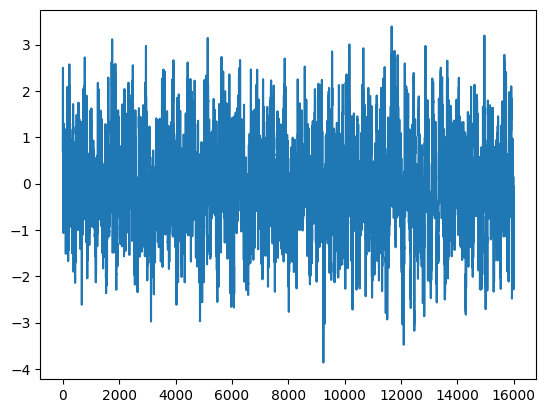

In [7]:
fig, ax = plt.subplots()
audio_original = random_background().astype(np.float32)

ax.plot(np.arange(audio_original.shape[0]), audio_original)
spectrogram = tf.signal.stft(
      audio_original, frame_length=255, frame_step=128)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.math.log(spectrogram).numpy()
plt.show()

In [13]:
def generate_noise_data(amount):
    x_temp = []
    for i in tqdm(range(amount)):
        audio_original = random_background().astype(np.float32)
        spectrogram = tf.signal.stft(
            audio_original, frame_length=128, frame_step=128)
        spectrogram = tf.abs(spectrogram)
        x_temp.append(spectrogram)
    y_temp = np.zeros((amount, 4))
    y_temp[:,0] = 1
    return np.array(x_temp), y_temp

In [18]:
x_train, y_train = generate_noise_data(20000)

100%|██████████| 20000/20000 [01:10<00:00, 282.38it/s]


In [15]:
print(x_train.shape)

(80000, 62, 65)


In [19]:
np.savez("augmented_data/val/noise", data=x_train)

In [17]:
x_val, y_val = generate_noise_data(20000)

100%|██████████| 20000/20000 [01:18<00:00, 255.37it/s]


In [18]:
x_train = np.expand_dims(x_train, axis=3)
x_val = np.expand_dims(x_val, axis=3)
print(x_train.shape)
print(x_val.shape)

(80000, 124, 129, 1)
(20000, 124, 129, 1)


In [19]:
np.savez("augmented_data/train/background_noise_spec", data=x_train)
np.savez("augmented_data/val/background_noise_spec", data=x_val)

In [2]:
training_data = np.load("augmented_data/train/training_data_resampled.npz")
validation_data = np.load("augmented_data/val/val_data_resampled.npz")

In [4]:
x_train = training_data["x"]
y_train = training_data["y"]
x_val = validation_data["x"]
y_val = validation_data["y"]
# SHUFFLE_BUFFER_SIZE = len(x_train)
# BATCH_SIZE = 8

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).shuffle(SHUFFLE_BUFFER_SIZE)
# val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [8]:
SHUFFLE_BUFFER_SIZE = len(x_train)
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).shuffle(SHUFFLE_BUFFER_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [8]:
import math
from tensorflow.python.keras.utils import data_utils
class DataGenerator(data_utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        print(self.x.shape)
        print(self.y.shape)
        self.batch_size = batch_size

    def __len__(self):
        return int(math.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array(batch_x, dtype=np.float32), np.array(batch_y, dtype=np.float32)
    
train_gen = DataGenerator(x_train, y_train, 64)
val_gen = DataGenerator(x_val, y_val, 64)

(319106, 62, 65, 1)
(319106, 4)
(80457, 62, 65, 1)
(80457, 4)


In [11]:
from tensorflow.python.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.models import Sequential
input_shape = x_train.shape[1:]
norm_layer = tf.keras.layers.Normalization()
model = Sequential([
    layers.Input(shape=input_shape),
    # norm_layer,
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1'),
    MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer2'),
    MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
    Flatten(),
    Dropout(0.2),
    Dense(
        40,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
    Dense(
        4, 
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])
model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 62, 65, 4)         40        
_________________________________________________________________
max_pooling1 (MaxPooling2D)  (None, 31, 32, 4)         0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 31, 32, 4)         148       
_________________________________________________________________
max_pooling2 (MaxPooling2D)  (None, 15, 16, 4)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 960)               0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 40)               

In [22]:
from tensorflow.python.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.models import Model
input_shape = x_train.shape[1:]
input_net = layers.Input(shape=input_shape)
# norm_layer,
conv1 = Conv2D(8, 5, 
        padding='same',
        activation='relu',
        # kernel_regularizer=regularizers.l2(0.001),
        name='conv_layer1')(input_net)
max_pool1 = MaxPooling2D(name='max_pooling1', pool_size=(2,2))(conv1)
conv2 = Conv2D(4, 3, 
        padding='same',
        activation='relu',
        # kernel_regularizer=regularizers.l2(0.001),
        name='conv_layer2')(max_pool1)
max_pool2 = MaxPooling2D(name='max_pooling2', pool_size=(2,2))(conv2)
conv3 = Conv2D(1, 3, 
        padding='same',
        activation='relu',
        # kernel_regularizer=regularizers.l2(0.01),
        name='conv_layer3')(max_pool2)
max_pool3 = MaxPooling2D(name='max_pooling3', pool_size=(4,4))(input_net)
merge_layer = Add()([max_pool2, max_pool3])
flat = Flatten()(merge_layer)
drop = Dropout(0.1)(flat)
fc_1 = Dense(
    40,
    activation='softmax',
#     kernel_regularizer=regularizers.l2(0.001),
    name='hidden_layer1'
)(drop)
# fc_2 = Dense(
#     64,
#     activation='relu',
#     kernel_regularizer=regularizers.l2(0.001),
#     name='hidden_layer2'
# )(fc_1)
output_net = Dense(
    4, 
    activation='softmax',
    # kernel_regularizer=regularizers.l2(0.001),
    name='output'
)(fc_1)
model = Model(inputs = input_net, outputs = output_net)
model.build(input_shape)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 78, 129, 1)] 0                                            
__________________________________________________________________________________________________
conv_layer1 (Conv2D)            (None, 78, 129, 8)   208         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling1 (MaxPooling2D)     (None, 39, 64, 8)    0           conv_layer1[0][0]                
__________________________________________________________________________________________________
conv_layer2 (Conv2D)            (None, 39, 64, 4)    292         max_pooling1[0][0]               
____________________________________________________________________________________________

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint.model",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [13]:
EPOCHS = 30
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
4987/4987 [==============================] - 18s 2ms/step - loss: 0.4221 - accuracy: 0.8833 - val_loss: 0.2538 - val_accuracy: 0.9328
INFO:tensorflow:Assets written to: checkpoint.model\assets
Epoch 2/30
4987/4987 [==============================] - 15s 3ms/step - loss: 0.2610 - accuracy: 0.9280 - val_loss: 0.2367 - val_accuracy: 0.9383
INFO:tensorflow:Assets written to: checkpoint.model\assets
Epoch 3/30
4987/4987 [==============================] - 14s 3ms/step - loss: 0.2395 - accuracy: 0.9360 - val_loss: 0.2178 - val_accuracy: 0.9432
INFO:tensorflow:Assets written to: checkpoint.model\assets
Epoch 4/30
4987/4987 [==============================] - 11s 2ms/step - loss: 0.2227 - accuracy: 0.9415 - val_loss: 0.2207 - val_accuracy: 0.9436
Epoch 5/30
4987/4987 [==============================] - 12s 2ms/step - loss: 0.2157 - accuracy: 0.9445 - val_loss: 0.2094 - val_accuracy: 0.9464
INFO:tensorflow:Assets written to: checkpoint.model\assets
Epoch 6/30
4987/4987 [=================

Text(0, 0.5, 'Accuracy [%]')

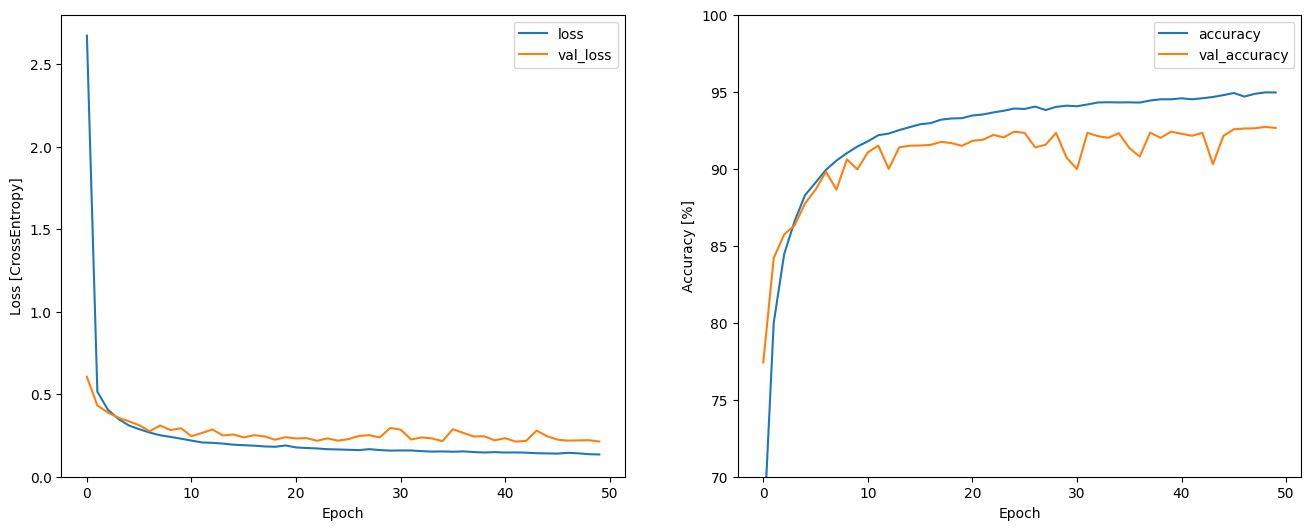

In [20]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([70, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [9]:
model.evaluate(val_gen, return_dict=True)

2515/2515 [==============================] - 4s 2ms/step - loss: 0.1740 - accuracy: 0.9570


{'loss': 0.17400510609149933, 'accuracy': 0.9569708108901978}

In [14]:
y_pred = model.predict(val_gen)

In [15]:
y_pred = tf.argmax(y_pred, axis=1)

In [11]:
print(y_pred.shape)

(80457,)


In [18]:
y_true = np.argmax(y_val, axis=1)
print(y_true.shape)

(82129,)


In [39]:
y_true = tf.concat(np.array(y_val).tolist(), axis=0)

KeyboardInterrupt: 

In [16]:
commands = ["noise", "Non-target", "Sheila", "Marvin"]

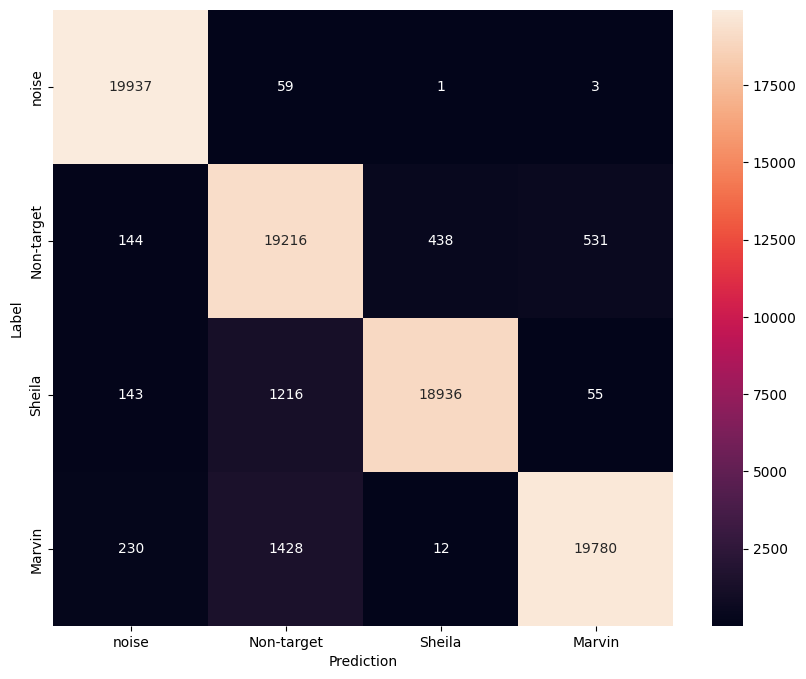

In [19]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [21]:

complete_train_X = np.concatenate((x_train, x_val))

In [22]:
converter2 = tf.lite.TFLiteConverter.from_saved_model("checkpoint.model copy")
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for i in range(0, len(complete_train_X), 100):
        # Get sample input data as a numpy array in a method of your choosing.
        yield [complete_train_X[i:i+100]]
converter2.representative_dataset = representative_dataset_gen
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter2.convert()
open("converted_model_mod.tflite", "wb").write(tflite_quant_model)

54520